# Credit card fraud detector using Amazon Fraud Detector service model

## Investigate and process the data

In [ ]:
pip install --upgrade imbalanced-learn

In [1]:
#Use the next command if you dont have the dataset on S3
#%%bash
#wget https://fraud-detector-trainingbucket-vztdzvdkor65.s3.amazonaws.com/hashed-transacciones.csv
from IPython.display import clear_output
from datetime import datetime
#from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline

import os
import sys
import json
import uuid
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import time

In [2]:
s3_resource = boto3.resource('s3')
#replace with your bucket and dataset file information
S3_BUCKET      = "fraud-detector-trainingbucket-vztdzvdkor65"
S3_FILE        = "hashed-transacciones.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

s3_resource.Bucket(S3_BUCKET).download_file(S3_FILE, 'dataset.csv')

In [45]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data = pd.read_csv('dataset.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [46]:
print(data.columns)
data.describe()

Index(['Fecha', 'Tipología', 'Canal', 'Segmento', 'Rut', 'Dv', 'CtaOri', 'CtaDes', 'NomDes', 'NomBancDes', 'RUTDES', 'MONTO', 'Fraude', 'IPCLI'], dtype='object')


,MONTO
count,1.800593e+06
mean,1.859659e+05
std,1.026486e+06
min,0.000000e+00
25%,8.000000e+03
50%,2.900000e+04
75%,1.005080e+05
max,7.020000e+08


Begining the transformation process to make the dataset Amazon FraudDetector compatible.

In [8]:
# to lowercase
data.columns = map(str.lower, data.columns)
data.head(10)

,fecha,tipología,canal,segmento,rut,dv,ctaori,ctades,nomdes,nombancdes,rutdes,monto,fraude,ipcli
0,2020-07-01 05:02:52,Pagos y Transferencias,WEB,PF,d6d90be138824500752ead6079eb94c6,45c48cce2e2d7fbdea1afc51c7c6ad26,d5ccfbb8aac8a72872be2abe9d6564e6,354fbe09a884c8991ea1c2789789a281,Enrique Cerda,Banco de Chile,cd8ff4b5ef589c3b1b3ecceb3e9b0df0,100000.0,NO,86.194.42.88
1,2020-07-01 05:03:55,Pagos y Transferencias,APP,PF,9f5a68cf314cc894aa20554712a1147e,a87ff679a2f3e71d9181a67b7542122c,6a3f3016086a6f7b3e6a58d045b83b47,00f9d5c40b3df68b62782657baa20dd3,Martín Espinoza,Banco Estado,4dec489afe5ab8557e249008ea35b071,80000.0,NO,191.125.159.126
2,2020-07-01 05:03:45,Pagos y Transferencias,APP,PF,71f005628d8d54570bae53683ae4d763,1679091c5a880faf6fb5e6087eb1b2dc,a480748a1cc5dac7e91ab2d50ac37eb8,a62332d06104519c214ecb1b85d7886d,Jesús Manuel Fuentes Trejo,Scotiabank Azul-Ex BBVA,f9f0deee98b18e596ce618bb5156c7a9,500000.0,NO,192.168.88.137
3,2020-07-01 05:04:36,Pagos y Transferencias,WEB,PF,0000f055c82bcc9734d7337f8b04a343,45c48cce2e2d7fbdea1afc51c7c6ad26,5ef2e1aa2e54aa3621e423d7e10457f6,4d2b0c4457603722873966163a7a7727,Ignacio guaman leiva,Banco del Estado de Chile,a1b9e4ecc3d128a3b21108c3095a388a,50000.0,NO,186.11.63.232
4,2020-07-01 05:05:54,Pagos y Transferencias,WEB,PJ,09826cb92f42cdefed122bafb016073d,a5f3c6a11b03839d46af9fb43c97c188,7bc1be694e088fb0bd327c16548c09ef,7bc1be694e088fb0bd327c16548c09ef,newiol/bic.iol.Transferencias.tef.tefa3ros,IENQ005FP_ConfTrEjecutada,19b590e8c411d27471d9e2769c8c6922,0.0,NO,201.239.76.169
5,2020-07-01 05:06:55,Pagos y Transferencias,APP,PF,48f955f75038d146f4af6c6806611251,1679091c5a880faf6fb5e6087eb1b2dc,4e2621310e8452a0a1154b1546c6182f,d7dd5bc4997fdeac6c690d45f0498b64,Nicolas Pacheco,Banco Estado,a63a6c7d4d50e6c1c872a5cea20ffb21,5000.0,NO,191.116.235.221
6,2020-07-01 05:06:59,Pagos y Transferencias,WEB,PF,d6d90be138824500752ead6079eb94c6,45c48cce2e2d7fbdea1afc51c7c6ad26,d5ccfbb8aac8a72872be2abe9d6564e6,91692721d938c7b8497856d254ce7156,Soledad Grau,Banco del Estado de Chile,0d27bc042b7fe074b3c177a343fa5d6c,100000.0,NO,86.194.42.88
7,2020-07-01 05:07:31,Pagos y Transferencias,WEB,PF,0ce6dd6d1a7d998e0d4966a93bcbd908,8f14e45fceea167a5a36dedd4bea2543,fb10151d1969534ea06e2f36a7d4378a,b4759ca2c674b922ef1aa4be3ffe67af,Naoki Yamamura,Banco Santander-Santiago,af65d438f0d31b93d8b26d5b45bff3b7,129080.0,NO,200.83.115.154
8,2020-07-01 05:07:39,Pagos y Transferencias,WEB,PJ,53463c3a096b54a4a7788355bc0d2338,a5f3c6a11b03839d46af9fb43c97c188,7bc1be694e088fb0bd327c16548c09ef,7bc1be694e088fb0bd327c16548c09ef,newiol/bic.iol.Transferencias.tef.tefa3ros,IENQ005FP_ConfTrEjecutada,230d690cdfb6884960a06cd02a69b89e,0.0,NO,186.10.95.231
9,2020-07-01 05:08:27,Pagos y Transferencias,APP,PF,2a6f77372a158a99d147ee29b92c76f5,1679091c5a880faf6fb5e6087eb1b2dc,2d673174651819153ac861656b40d39c,1feec85a43be1b6581a98f827f69516c,Antonella Musa,Banco de Chile / Edwards-Citi,f3fbc4f12c6521154d76b0598c102d9b,6500.0,NO,192.168.88.137


In [9]:
# Map fraud labels text values to number
data['fraude'] = data['fraude'].map({'NO': 0, 'SI': 1})

In [10]:
# rename to the Fraud Detector name conventions 
data.rename(columns={'fecha':'EVENT_TIMESTAMP','fraude':'EVENT_LABEL', 'tipología':'tipologia'}, inplace=True)
print(data.columns)

Index(['EVENT_TIMESTAMP', 'tipologia', 'canal', 'segmento', 'rut', 'dv', 'ctaori', 'ctades', 'nomdes', 'nombancdes', 'rutdes', 'monto', 'EVENT_LABEL', 'ipcli'], dtype='object')


Lets check the class balance

In [ ]:
nonfrauds, frauds = data.groupby('EVENT_LABEL').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

count_class_0, count_class_1 = data.EVENT_LABEL.value_counts()
data.EVENT_LABEL.value_counts().plot(kind='bar', title='Count (EVENT_LABEL)');

An oversampling is required in order to work with Amazon FraudDetector. Since most columns are categorical the best candidate algorithm is the SMOTENC.

The SMOTENC cant handle null values, we need to replace those.

In [82]:
# Lets check for null values
data.isnull().sum()

Fecha          0
Tipología     15
Canal          0
Segmento       0
Rut            0
Dv             0
CtaOri         0
CtaDes         0
NomDes        10
NomBancDes     0
RUTDES         0
MONTO          0
Fraude         0
IPCLI          1
dtype: int64

In [ ]:
#Null numerics with the median
#imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
#data[['numcol']] = imputer.fit_transform(data[['numcol']])

In [12]:
# Null categorical with most commun value
print(data['tipologia'].value_counts())
print(data['nomdes'].value_counts())
print(data['ipcli'].value_counts())

def replace_tipologia(x):
    if pd.isnull(x):
        return 'Sin tipologia'
    else:
        return x
def replace_nomdes(x):
    if pd.isnull(x):
        return 'Sin destinatario'
    else:
        return x
def replace_ipcli(x):
    if pd.isnull(x):
        return '192.168.88.137'
    else:
        return x

Pagos y Transferencias    1800578
Name: tipologia, dtype: int64
newiol/bic.iol.Transferencias.tef.tefa3ros            178639
newiol/bic.iol.AccesoDirecto.fp.autorizaroperacion     23312
Raul Ibanez                                             5397
Raul ibanez                                             2546
Mainsoft S.A.                                           2392
                                                       ...  
Camila Nuñez lastra                                        1
janet jara                                                 1
José Rodrigo Sánchez Moya                                  1
Marcelo Muñoz Hidalgo                                      1
luomen                                                     1
Name: nomdes, Length: 771143, dtype: int64
192.168.88.137     387431
186.148.33.4         2432
186.10.95.231        2366
190.196.7.100        2090
186.148.32.228       1960
                    ...  
186.11.29.8             1
191.126.156.205         1
191.119.103.24

In [13]:
data['tipologia'] = data['tipologia'].map(replace_tipologia)
data['nomdes'] = data['nomdes'].map(replace_nomdes)
data['ipcli'] = data['ipcli'].map(replace_ipcli)
data.isnull().sum()

EVENT_TIMESTAMP    0
tipologia          0
canal              0
segmento           0
rut                0
dv                 0
ctaori             0
ctades             0
nomdes             0
nombancdes         0
rutdes             0
monto              0
EVENT_LABEL        0
ipcli              0
dtype: int64

Beginning the resampling process.

In [15]:
features = data.drop('EVENT_LABEL', axis=1).values
labels = (data['EVENT_LABEL'].values).astype('float32')

We will split our dataset into a train and test to evaluate the performance of our models. It's important to do so before any techniques meant to alleviate the class imbalance are used. This ensures that we don't leak information from the test set into the train set.

In [16]:
X, X_test, y, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

In [17]:
counter = Counter(y)
print(counter)

Counter({0.0: 1620492, 1.0: 41})


Doing a SMOTE oversampling of the fraudulent class.

In [18]:
smote_nc = SMOTENC(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12], random_state=0, sampling_strategy={1: 500})
X_smt, y_smt = smote_nc.fit_resample(X, y)

In [19]:
counter = Counter(y_smt)
print(counter)

Counter({0.0: 1620492, 1.0: 500})


In [ ]:
#random pandas undersampling
#df_class_0 = data[data['EVENT_LABEL'] == 0]
#df_class_0_under = df_class_0.sample(400000)
#print(df_test_under.EVENT_LABEL.value_counts())

In [ ]:
#random pandas oversampling
#df_class_1 = data[data['EVENT_LABEL'] == 1]
#df_class_1_over = df_class_1.sample(450, replace=True)
#print(df_test_over.EVENT_LABEL.value_counts())

In [ ]:
#mergin the under and over sampled data
#data = pd.concat([df_class_1_over, df_class_0_under], axis=0)
#print(data.EVENT_LABEL.value_counts())
#data.describe()

Getting the train DataFrame back together with the class column and the test portion without the oversampling.

In [20]:
saved_cols = data.drop('EVENT_LABEL', axis=1).columns
print(saved_cols)
data = pd.DataFrame(X_smt, columns = saved_cols)
data['EVENT_LABEL']=y_smt.astype(int)
data.head(10)

Index(['EVENT_TIMESTAMP', 'tipologia', 'canal', 'segmento', 'rut', 'dv', 'ctaori', 'ctades', 'nomdes', 'nombancdes', 'rutdes', 'monto', 'ipcli'], dtype='object')


,EVENT_TIMESTAMP,tipologia,canal,segmento,rut,dv,ctaori,ctades,nomdes,nombancdes,rutdes,monto,ipcli,EVENT_LABEL
0,2020-07-31 09:04:00,Pagos y Transferencias,APP,PF,98a1aff50d1bdeb2cab7efce43ca1ca9,cfcd208495d565ef66e7dff9f98764da,3bb0b467a2d40048578fac0aa235d269,3b2572a3c2a1a5b7c2f6166aa8271771,Jaime Hernandez,Banco Crédito Inversiones (BCI),d13c8dfc3a78ed64f81af0306da53a08,30000,201.219.236.254,0
1,2020-07-21 15:45:04,Pagos y Transferencias,WEB,PF,fb0a2dbc06d87d173cfa7c83f5f00200,45c48cce2e2d7fbdea1afc51c7c6ad26,bf7f5c1ac28c72b583c53f7a99a56f72,abc912bf4f9030b67311ce12d638dbe4,Cesar Aguayo,Banco Credito Inversiones,91c63c7bc0dd4bbffadc32bdd5d0b806,10000,181.75.249.161,0
2,2020-07-04 18:31:31,Pagos y Transferencias,APP,PF,78bfe16c176100d1dc694717d76de2b6,a5f3c6a11b03839d46af9fb43c97c188,1a804550ff5af54a8271a419618037b3,f1a1e44fabf79a95e89cc218db5756bb,Claudia,Banco Estado,76136315727ebc60c1232001d5be29f8,0,192.168.88.137,0
3,2020-07-28 15:48:45,Pagos y Transferencias,WEB,PF,4287c9c7aaf4c2374467b0a879df0ad6,8f14e45fceea167a5a36dedd4bea2543,ba25f87af53524c99e2dc6f54a795be4,d834f9f7cb45e91d0cad98d95a10dc03,María José Levill Levill,Banco del Estado de Chile,6cecc261ad257ec1b4c87842887b8461,50000,181.42.13.202,0
4,2020-07-14 19:32:30,Pagos y Transferencias,WEB,PF,900c10c848b497ee821cf33878fdb70c,a5f3c6a11b03839d46af9fb43c97c188,bfdb25af2a61f8351c36fb48d17970c8,d3b769b8d6678199cd949e1e94cd2400,hugo echegoyen muñoz,Banco Itaú,f9fb964865d5e2c48cb60f481cd7d098,22000,181.226.243.79,0
5,2020-07-14 10:22:30,Pagos y Transferencias,APP,PF,be541b227f766287b759c37f14e761e8,a5f3c6a11b03839d46af9fb43c97c188,f831aa30976158c429b859bb8e3047a4,a33640e95daf69711aa691519b9cae2a,Patricia vega,Banco Estado,1056fbef1d87a899743e43bb6ab57474,480000,192.168.88.137,0
6,2020-07-02 11:15:19,Pagos y Transferencias,NEW APP,PF,d798aff07dd018bdeac6030ef7e76e9b,e4da3b7fbbce2345d7772b0674a318d5,7d0a875de53eba45be2472888e19cc88,2e89083d4c7d0f72329126284ea669fd,Pia Sánchez roa,Banco Estado,ee8fc18b364287faaa7628656a4f5780,20000,192.168.88.137,0
7,2020-07-05 20:28:39,Pagos y Transferencias,APP,PF,2f7d952f813152206cccc14f65f5d6cf,a87ff679a2f3e71d9181a67b7542122c,758952a9f5f2d76c4729c41d4e7affaa,0daaef34cd31ab94923b294e385cec5c,vakeska ramirez,Banco Falabella,d049ec5652504536984a3d788b3f72f5,19990,192.168.88.137,0
8,2020-07-28 11:09:58,Pagos y Transferencias,WEB,PJ,e21177809f62d0480621f640e28ee26c,c81e728d9d4c2f636f067f89cc14862c,7bc1be694e088fb0bd327c16548c09ef,7bc1be694e088fb0bd327c16548c09ef,newiol/bic.iol.AccesoDirecto.fp.autorizaropera...,IENQ003TX_InsTefRealizada,708ee267267adfe4545d0940df6f51c2,0,200.104.227.97,0
9,2020-07-07 23:52:39,Pagos y Transferencias,APP,PF,0413b03625ce2e70360f0e2a3bf27413,8f14e45fceea167a5a36dedd4bea2543,6b08b93b131b0d97e721706094a2a5ba,8136ccd26756e5c2fd4ea1374a587341,Diego Taiba,Banco Santander-Santiago,128c7f39cc2ee38a062b3afbb231b5d7,7000,192.168.88.137,0


In [56]:
test = pd.DataFrame(X_test, columns = saved_cols)
test['EVENT_LABEL']=y_test.astype(int)

EVENT_TIMESTAMP    180060
tipologia          180060
canal              180060
segmento           180060
rut                180060
dv                 180060
ctaori             180060
ctades             180060
nomdes             180060
nombancdes         180060
rutdes             180060
monto              180060
ipcli              180060
dtype: int64

In [59]:
#validating the test dataset
nonfrauds, frauds = test_label.groupby('EVENT_LABEL').size()
print('Number of frauds in test data: ', frauds)
print('Number of non-frauds in test data: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds in test data:  4
Number of non-frauds in test data:  180056
Percentage of fradulent data: 0.0022214817283127846


Number of frauds:  500
Number of non-frauds:  1620492
Percentage of fradulent data: 0.030845309538850285


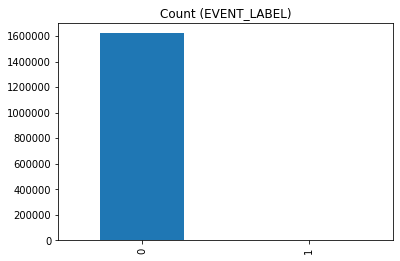

In [21]:
#validating the resampled data
nonfrauds, frauds = data.groupby('EVENT_LABEL').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

count_class_0, count_class_1 = data.EVENT_LABEL.value_counts()
data.EVENT_LABEL.value_counts().plot(kind='bar', title='Count (EVENT_LABEL)');

Uploading the data for training

In [ ]:
from io import StringIO # python3; python2: BytesIO 

csv_buffer = StringIO()
data.to_csv(csv_buffer, index=False)
s3_resource.Object(S3_BUCKET, 'dataset-training.csv').put(Body=csv_buffer.getvalue())

Uploading the data for testing

In [ ]:
csv_buffer = StringIO()
test.to_csv(csv_buffer, index=False)

s3_resource.Object(S3_BUCKET, 'dataset-test.csv').put(Body=csv_buffer.getvalue())

Once we have the datasets ready we need create the necesary entities for build and deploy the fraud detection model. This can be done within the Amazon Fraud Detector console visually or through the API as shown in the following seccion.

In [25]:
# -- initialize the AFD client 
afd_resource = boto3.client('frauddetector')

# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")
print(sufx)

20200908


In [26]:
# -- This is all you need to fill out. Once complete simply interactively run each code cell. --  
# your_entity_name
ENTITY_TYPE    = "transferencias{0}".format(sufx) 
ENTITY_DESC    = "transferencias entre terceros: {0}".format(sufx) 
# your_event_type
EVENT_TYPE     = "transferencias_bancarias{0}".format(sufx) 
EVENT_DESC     = "eventos de transferencias bancarias: {0}".format(sufx) 
# your_model_name
MODEL_NAME     = "fraud_det_model{0}".format(sufx) 
MODEL_DESC     = "model trained on: {0}".format(sufx) 
# your_detector_name
DETECTOR_NAME  = "fraud_det_detector{0}".format(sufx)                        
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx) 

# Replace the ARN Role with the resources created in CloudFormation stack
ARN_ROLE       = "arn:aws:iam::028453496397:role/fraud-detector-NotebookInstanceExecutionRole-1DOTG53ZN51IL" 

### 1. Profile Your Dataset 
-----

    
<div class="alert alert-info"> 💡 <strong> Profiling </strong>

The function below will: 1. profile your data, creating descriptive statistics, 2. perform basic data quality checks (nulls, unique variables, etc.), and 3. return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and TRAIN your MODEL.


</div>

In [27]:
# --- no changes; just run this code block ---
def summary_stats(df):
    """ Generate summary statistics for a panda's data frame 
        Args:
            df (DataFrame): panda's dataframe to create summary statistics for.
        Returns:
            DataFrame of summary statistics, training data schema, event variables and event lables 
    """
    df = df.copy()
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper --  
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"].str.contains("ipaddress|ip_address|ipcli"), 'feature_type'] = "IP_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("email|email_address|emailaddr"), 'feature_type'] = "EMAIL_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("canal|channel"), 'feature_type'] = "USERAGENT"
    df_stats.loc[df_stats["feature_name"].str.contains("monto|amount"), 'feature_type'] = "PRICE"
    df_stats.loc[df_stats["feature_name"].str.contains("nomdes|name"), 'feature_type'] = "BILLING_NAME"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    # -- variable warnings -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.9) & (df_stats['feature_type'] == "CATEGORY") ,'feature_warning' ] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    # -- target check -- 
    exclude_fields  = df_stats.loc[(df_stats['feature_warning'] != 'NO WARNING')]['feature_name'].to_list()
    event_variables = df_stats.loc[(~df_stats['feature_name'].isin(['EVENT_LABEL', 'EVENT_TIMESTAMP']))]['feature_name'].to_list()
    event_labels    = df["EVENT_LABEL"].unique().tolist()
    
    trainingDataSchema = {
        'modelVariables' : df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list(),
        'labelSchema'    : {
            'labelMapper' : {
                'FRAUD' : [str(df["EVENT_LABEL"].value_counts().idxmin())],
                'LEGIT' : [str(df["EVENT_LABEL"].value_counts().idxmax())]
            }
        }
    }
    
    
    model_variables = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list()
   
    
    # -- label schema -- 
    label_map = {
        'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
        'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
    }
    
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(trainingDataSchema)
    print("\n")
    
    return df_stats, trainingDataSchema, event_variables, event_labels

# -- connect to S3, snag file, and convert to a panda's dataframe --
#s3   = boto3.resource('s3')
#obj  = s3.Object(S3_BUCKET, S3_FILE)
#body = obj.get()['Body']
#df   = pd.read_csv(body)

# -- call profiling function -- 
df_stats, trainingDataSchema, eventVariables, eventLabels = summary_stats(data)

--- summary stats ---
       feature_name   dtype    count  nunique  null  not_null  null_pct  nunique_pct     feature_type feature_warning
0   EVENT_TIMESTAMP  object  1620992   998907     0   1620992       0.0       0.6162  EVENT_TIMESTAMP      NO WARNING
1         tipologia  object  1620992        2     0   1620992       0.0       0.0000         CATEGORY      NO WARNING
2             canal  object  1620992        4     0   1620992       0.0       0.0000        USERAGENT      NO WARNING
3          segmento  object  1620992        2     0   1620992       0.0       0.0000         CATEGORY      NO WARNING
4               rut  object  1620992   196416     0   1620992       0.0       0.1212         CATEGORY      NO WARNING
5                dv  object  1620992       12     0   1620992       0.0       0.0000         CATEGORY      NO WARNING
6            ctaori  object  1620992   252756     0   1620992       0.0       0.1559         CATEGORY      NO WARNING
7            ctades  object  16209

### 2. Create Variables
-----

<div class="alert alert-info"> 💡 <strong> Create Variables. </strong>

The following section will automatically create your modeling input variables and your model scoring variable for you. 

</div>

In [ ]:
# --- no changes just run this code block ---
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    afd_resource.put_label(
                name = str(label_summary.idxmin()),
                description = 'FRAUD')
    
    afd_resource.put_label(
                name = str(label_summary.idxmax()),
                description = 'LEGIT')
    
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(df_stats, MODEL_NAME):
    """
    Returns a variable list of model input variables, checks to see if variable exists,
    and, if not, then it adds the variable to Fraud Detector 
    
    Arguments: 
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    enrichment_features = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'BILLING_NAME', 'PRICE']))]['feature_name'].to_dict()
    enrichment_type = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'BILLING_NAME', 'PRICE']))]['feature_type'].to_dict()
    numeric_features = df_stats.loc[(df_stats['feature_type'].isin(['NUMERIC']))]['feature_name'].to_dict()
    categorical_features = df_stats.loc[(df_stats['feature_type'].isin(['CATEGORY']))]['feature_name'].to_dict()
    
    variable_list = []
    # -- first do the enrichment features
    for feature in enrichment_features.keys(): 
        variable_list.append( {'name' : enrichment_features[feature]+"_imp"})
        try:
            varname = enrichment_features[feature]+"_imp"
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(enrichment_features[feature]))
            if enrichment_type[feature] == "PRICE":
                resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0', 
                    description = enrichment_features[feature],
                    variableType = enrichment_type[feature] )
            else:
                resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = enrichment_features[feature],
                    variableType = enrichment_type[feature] )
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : numeric_features[feature]+"_imp"})
        try:
            varname = numeric_features[feature]+"_imp"
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(numeric_features[feature]))
            resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = numeric_features[feature],
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : categorical_features[feature]+"_imp"})
        try:
            varname = categorical_features[feature]+"_imp"
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(categorical_features[feature]))
            resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = categorical_features[feature],
                    variableType = 'CATEGORICAL' )
    
    # -- create a model score feature  
    model_feature = "{0}_insightscore".format(MODEL_NAME)  
    # variable_list.append( {'name' : model_feature})
    try:
        afd_resource.get_variables(name=model_feature)
    except:
        print("Creating variable: {0}".format(model_feature))
        resp = afd_resource.create_variable(
                name = model_feature,
                dataType = 'FLOAT',
                dataSource ='MODEL_SCORE',
                defaultValue = '0.0', 
                description = model_feature,
                variableType = 'NUMERIC' )
    
    return variable_list


model_variables = create_variables(df_stats, MODEL_NAME)
print("\n --- model variable dict --")
print(model_variables)


model_label = create_label(data, "EVENT_LABEL")
print("\n --- model label schema dict --")
print(model_label)

### 3. Create Entity and Event Types
-----
    
<div class="alert alert-info"> 💡 <strong> Entity and Event. </strong>
    
The following code block will automatically create your entity and event types for you.

</div>

In [ ]:
#Amazon Fraud Detector expect the labels to be strings.
eventLabels = list(map(str, eventLabels))
print(eventLabels)

In [ ]:
# --- no changes just run this code block ---
response = afd_resource.put_entity_type(
    name        = ENTITY_TYPE,
    description = ENTITY_DESC
)
print("-- create entity --")
print(response)

response = afd_resource.put_event_type (
    name           = EVENT_TYPE,
    eventVariables = eventVariables,
    labels         = eventLabels,
    entityTypes    = [ENTITY_TYPE])
print("-- create event type --")
print(response)

### 4. Create & Train your Model
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [ ]:
# -- create our model --
response = afd_resource.create_model(
   description   = MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')
print("-- initalize model --")
print(response)

In [ ]:
# -- initializes the model, it's now ready to train -- 
S3_FILE        = "dataset-training.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

response = afd_resource.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
print("-- model training --")
print(response)

In [ ]:
# -- model training takes time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --")
stime = time.time()
while True:
    clear_output(wait=True)
    response = afd_resource.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '2.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize -- 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

### 5. Activate the Model and evaluate the performance
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [ ]:
response = afd_resource.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '2.0',
    status = 'ACTIVE'
)
print("-- activating model --")
print(response)

#-- wait until model is active 
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = afd_resource.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '2.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

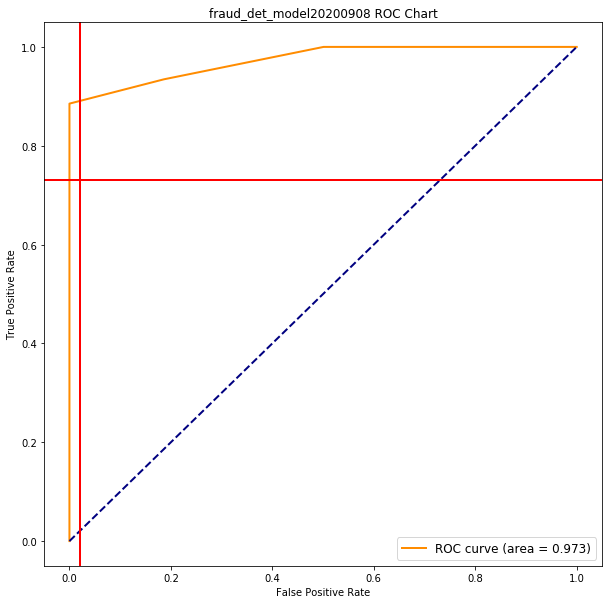

In [28]:
# -- model performance summary -- 
auc = afd_resource.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='2.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(afd_resource.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='2.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

### 6. Create Detector, generate Rules and assemble your Detector

-----
    
<div class="alert alert-info"> 💡 <strong> Generate Rules, Create and Publish a Detector. </strong>
    
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.
</div>

In [ ]:
# -- initialize your detector -- 
response = afd_resource.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

In [ ]:
# -- make rules -- 
model_stat = df_model.round(decimals=6)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if x['fpr'] == 0.06:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,x['threshold_prev'])
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "fraud"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "investigate"

print (" --- score thresholds 1% to 6% --- ")
print(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))

In [ ]:
print(m)

In [ ]:
rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = afd_resource.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")
rule_list    

In [ ]:
afd_resource.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId":MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : "2.0"}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 

In [ ]:
response = afd_resource.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)

Testing our model endpoint

In [40]:
s3_resource = boto3.resource('s3')
#replace with your bucket and dataset file information
S3_BUCKET      = "fraud-detector-trainingbucket-vztdzvdkor65"
S3_FILE        = "dataset-test.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

s3_resource.Bucket(S3_BUCKET).download_file(S3_FILE, 'dataset-test.csv')

In [81]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

test = pd.read_csv('dataset-test.csv', delimiter=',')
test.head(10)

,EVENT_TIMESTAMP,tipologia,canal,segmento,rut,dv,ctaori,ctades,nomdes,nombancdes,rutdes,monto,ipcli
0,2020-07-08 11:26:33,Pagos y Transferencias,APP,PF,8b7b9dc18f37bf63f95dd21bc153e392,45c48cce2e2d7fbdea1afc51c7c6ad26,06bb5bef0faf68e34425cfd721ac983e,b59e491ccfc02f404b1be01976b471e0,christian basoalto,Banco de Chile / Edwards-Citi,fd357482b5f76349fc81af3ba52e29b3,199999.0,192.168.88.137
1,2020-07-19 22:06:00,Pagos y Transferencias,APP,PF,c455c3cf1fc59f7e6aa7079b43625395,a87ff679a2f3e71d9181a67b7542122c,9a81863b7b1156dd84576b404efd847b,ee60570fc4f7efbfb4acd953884969e0,maria eugenia gonzalez videla,Banco Santander-Santiago,5845e9d5ed68b3333f8aaffa0f8a110e,130000.0,192.168.88.137
2,2020-07-31 11:59:45,Pagos y Transferencias,APP,PF,9d4d67cab011a7a9e3171d8096d8a5ac,a5f3c6a11b03839d46af9fb43c97c188,2a2a2feb2ee7b91b962937d3df4fa4fd,f54d524ade8984180c9ccb50e74e9768,Cassandra Ornano,Banco Santander-Santiago,e242a0a3af653999d878598dd7025810,15890.0,192.168.88.137
3,2020-07-02 23:42:51,Pagos y Transferencias,WEB,PF,8f0c2c558aed3b7b27961f9102d19bfe,e4da3b7fbbce2345d7772b0674a318d5,ce4b1bbc50cad868d8c9152582bc8652,e3eb10ec1a4ec2a86826f00f8df019ee,Claudio Jara Molina,Banco Santander-Santiago,c72af796f3ce0fae237e1c6b216ceb28,20000.0,186.11.62.185
4,2020-07-02 11:22:15,Pagos y Transferencias,APP,PF,7c56e083a2408573386883ae08da9a72,c9f0f895fb98ab9159f51fd0297e236d,1d2089c0b7a1449669b29fcbe6ffa27b,f0ea88913593ba576a22d67e52dc5b99,hugo muñoz,Banco Falabella,ce846b2b5b17b28180d9e4d160cfd453,120000.0,192.168.88.137
5,2020-07-26 20:07:28,Pagos y Transferencias,WEB,PF,496b9cb13a8ccec4dab279a53555adf6,eccbc87e4b5ce2fe28308fd9f2a7baf3,95b20c920b33cc0ed271ab7eba1c1cd4,b261ea0ad9a0d4065d079906494ce454,matilde maddaleno herrera,Banco de Chile,d216482286e31df42bc1f025e90fd5de,12000.0,201.239.242.46
6,2020-07-21 08:46:07,Pagos y Transferencias,WEB,PJ,d41e62a45537cc9e47da4aa4856beed6,a87ff679a2f3e71d9181a67b7542122c,a3d2de7675556553a5f08e4c88d2c228,a3d2de7675556553a5f08e4c88d2c228,newiol/bic.iol.Transferencias.tef.tefa3ros,IENQ005FP_ConfTrEjecutada,fb21e94fb209a71e831f6019fad298bc,0.0,190.45.200.29
7,2020-07-17 21:32:16,Pagos y Transferencias,APP,PF,fa54fef00d81db63d36ffa08d26c43ff,45c48cce2e2d7fbdea1afc51c7c6ad26,b4ec8b2dd178d847c6df71da9264d352,b12a6281f35a48703dd04ceeac690dac,Laura Vera,Banco Estado,bbddfd8cc3eafb60001c5c06cdc6183b,2300.0,192.168.88.137
8,2020-07-13 21:12:01,Pagos y Transferencias,WEB,PF,7d5e960687d13c11ccce83bd0518d717,c81e728d9d4c2f636f067f89cc14862c,877b46e92286b0aa728e4ae16c65134d,e9b7a87bb5689e44b24a68e033766aea,texia navarro pasten,Banco del Estado de Chile,bcd414eac4268b89b98639b012b6af76,90000.0,201.215.86.174
9,2020-07-17 14:35:05,Pagos y Transferencias,Webmobile,PF,3176e3cf35af1994d3b0ba7a13237d74,c4ca4238a0b923820dcc509a6f75849b,031af4f2f5ea6a3d51e69fd55ddc1903,e634726547937b614ebefa9986a6537e,Cristian aguero,Banco del Estado de Chile,c4c1b24523ef03e3aecc2c6da0a83b55,9000.0,152.231.126.216


Cleaning the test dataset from training columns and defining the start datetime.

In [71]:
record_count = 404
model_variables = [column for column in test.columns if column not in  ['EVENT_LABEL', 'EVENT_TIMESTAMP']]
#dateTimeObj = datetime.strptime('Sep 3 2013  12:00AM', '%b %d %Y %I:%M%p')
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y-%m-%dT%H:%M:%SZ")
print(' '.join(model_variables))

tipologia canal segmento rut dv ctaori ctades nomdes nombancdes rutdes monto ipcli


In [72]:
import uuid

# test the endpoint with a single prediction.
eventId = uuid.uuid1()
testrecord = test_label[model_variables].head(15).astype(str).to_dict(orient='records')[6]
pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='2',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  testrecord)
print(pred)

{'modelScores': [{'modelVersion': {'modelId': 'fraud_det_model20200908', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '2.0'}, 'scores': {'fraud_det_model20200908_insightscore': 432.0}}], 'ruleResults': [{'ruleId': 'rule1_fraud_det_model20200908', 'outcomes': ['investigate']}], 'ResponseMetadata': {'RequestId': '4e7d4056-fc33-4d26-b6a9-1d9b561bcc89', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 14 Sep 2020 20:41:17 GMT', 'x-amzn-requestid': '4e7d4056-fc33-4d26-b6a9-1d9b561bcc89', 'content-length': '277', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


The next block will use some parallelization to run several test against the fraud detector endpoint.

In [89]:
import dask 
import time
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% }</style>"))

start = time.time()

@dask.delayed
def _predict(record):
    eventId = uuid.uuid1()
    try:
        pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='2',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        
        record["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
        record["outcomes"]= pred['ruleResults'][0]['outcomes']
        return record
    
    except:
        pred  = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        record["score"]   = "-999"
        record["outcomes"]= "error"
        return record

#just testing with 200 samples, increase the record_count variable o remove the .head to test the entire test dataset
predict_data  = test[model_variables].head(record_count).astype(str).to_dict(orient='records')
predict_score = []

i=0
for record in predict_data:
    clear_output(wait=True)
    rec = dask.delayed(_predict)(record)
    predict_score.append(rec)
    i += 1
    print("current progress: ", round((i/record_count)*100,2), "%" )
    
predict_recs = dask.compute(*predict_score)

# Calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_recs))

current progress:  100.0 %
Process took 4.35 seconds
Scored 404 records


In [95]:
# lets take a look to the predicted frauds
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
predictions.loc[predictions['score'].astype('float32') > 875]

,tipologia,canal,segmento,rut,dv,ctaori,ctades,nomdes,nombancdes,rutdes,monto,ipcli,score,outcomes
401,Sin tipologia,WEB,PF,05ef2b2ec63b0451e753da506407ce59,c4ca4238a0b923820dcc509a6f75849b,8d8b98d0765127cadd3e850af72f8b4d,35298865c6b58ae65570b30e2cfaf83b,victoria,Banco del Estado de Chile,b2d3f8b557944f6780d6d60f7b923eaf,200000.0,186.11.58.2,1000,[fraud]
402,Pagos y Transferencias,WEB,PF,4a379677c0f2edd6a98cebc2c46f4707,45c48cce2e2d7fbdea1afc51c7c6ad26,457ad069eebf1f77dd529fca55e1ec6a,952cd2c29bb380044ecb086d43acdb05,alan cerda,Banco del Estado de Chile,781c1bcc58864eab9c42b5e2a8b40660,200000.0,186.10.157.179,999,[fraud]


In [78]:
data[(data["NomDes"]=="victoria") & (data["RUTDES"]== 'b2d3f8b557944f6780d6d60f7b923eaf')]

,Fecha,Tipología,Canal,Segmento,Rut,Dv,CtaOri,CtaDes,NomDes,NomBancDes,RUTDES,MONTO,Fraude,IPCLI
369910,2020-07-07 12:37:23,NaN,WEB,PF,05ef2b2ec63b0451e753da506407ce59,c4ca4238a0b923820dcc509a6f75849b,8d8b98d0765127cadd3e850af72f8b4d,35298865c6b58ae65570b30e2cfaf83b,victoria,Banco del Estado de Chile,b2d3f8b557944f6780d6d60f7b923eaf,200000.0,SI,186.11.58.2


In [79]:
data[(data["NomDes"]=="alan cerda") & (data["RUTDES"]== '781c1bcc58864eab9c42b5e2a8b40660')]

,Fecha,Tipología,Canal,Segmento,Rut,Dv,CtaOri,CtaDes,NomDes,NomBancDes,RUTDES,MONTO,Fraude,IPCLI
895701,2020-07-16 13:39:57,Pagos y Transferencias,WEB,PF,4a379677c0f2edd6a98cebc2c46f4707,45c48cce2e2d7fbdea1afc51c7c6ad26,457ad069eebf1f77dd529fca55e1ec6a,952cd2c29bb380044ecb086d43acdb05,alan cerda,Banco del Estado de Chile,781c1bcc58864eab9c42b5e2a8b40660,200000.0,SI,186.10.157.179


See the model metrics on CloudWatch and the prediction history in Fraud Detector.

In [ ]:
from io import StringIO
# save the results to a csv file and upload it to the output s3 bucket
csv_buffer = StringIO()
predictions.to_csv(csv_buffer, index=False)
s3_resource.Object(S3_BUCKET, MODEL_NAME + "precictions{}.csv".format(sufx)).put(Body=csv_buffer.getvalue())

Finish